# Heart dissease prediction ML model

This one needs more data treatment

### Data Dictionary

**age**  
Age in years.

---

**sex**  
- 1 = male  
- 0 = female

---

**cp – Chest Pain Type**  
- 0 = typical angina  
- 1 = atypical angina  
- 2 = non-anginal pain  
- 3 = asymptomatic

---

**trestbps**  
Resting blood pressure (in mm Hg on admission to the hospital)

---

**chol**  
Serum cholesterol in mg/dl

---

**fbs – Fasting Blood Sugar (> 120 mg/dl)**  
- 1 = true  
- 0 = false

---

**restecg – Resting Electrocardiographic Results**  
- 0 = normal  
- 1 = ST–T wave abnormality (T wave inversions and/or ST elevation or depression > 0.05 mV)  
- 2 = probable or definite left ventricular hypertrophy (Estes' criteria)

---

**thalach**  
Maximum heart rate achieved

---

**exang – Exercise Induced Angina**  
- 1 = yes  
- 0 = no

---

**oldpeak**  
ST depression induced by exercise relative to rest

---

**slope – Slope of the Peak Exercise ST Segment**  
- 0 = upsloping  
- 1 = flat  
- 2 = downsloping

---

**ca**  
Number of major vessels (0–3) colored by fluoroscopy

---

**thal**  
- 0 = error (mapped to NaN in original dataset)  
- 1 = fixed defect  
- 2 = normal  
- 3 = reversible defect

---

**target – Disease Indicator**  
- 0 = no disease  
- 1 = disease


In [1]:
import pandas as pd 
import numpy as np

df=pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
X=df.drop("target",axis=1)
Y=df["target"]


In [3]:
#perform one hot encoding on categorical columns
X=pd.get_dummies(X,columns=["cp","restecg","slope","thal","ca","exang",'fbs','sex'])


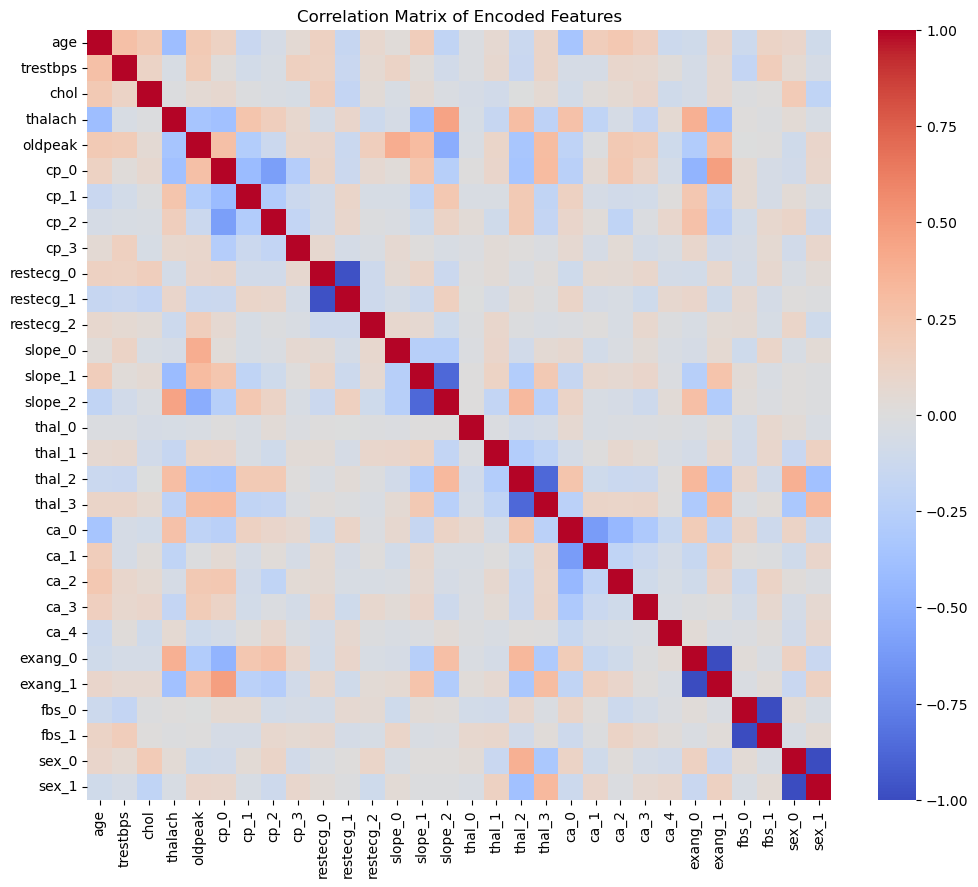

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
correlation_matrix = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Encoded Features')
plt.show()

## We find  heavelly correlated variables 
Such as sex Obviouslly or the binary ones, that we can eliminate


(303, 26)


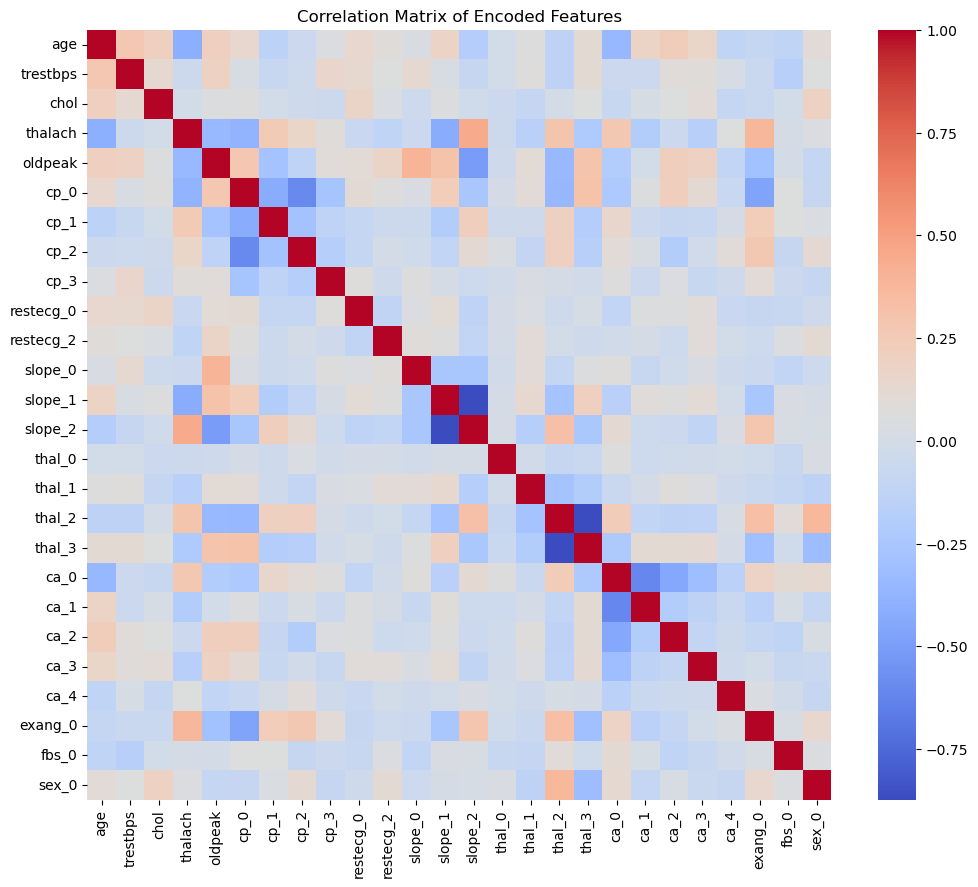

In [5]:
#Eliminate highly correlated features if correlation is below -0.9 (one of every pair)
def eliminate_highly_correlated_features(dataframe, threshold=0.9):
    corr_matrix = dataframe.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    reduced_dataframe = dataframe.drop(columns=to_drop)
    return reduced_dataframe
#we drop the selected columns from X and Y
X = eliminate_highly_correlated_features(X, threshold=0.9)
print (X.shape)
correlation_matrix = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Encoded Features')
plt.show()




Now we need to search for outliers in continious variables


In [6]:
from scipy import stats
import numpy as np

continuous_cols = ['age','trestbps','chol','thalach','oldpeak']

z_scores = np.abs(stats.zscore(df[continuous_cols]))
outliers = df[(z_scores > 3).any(axis=1)]
outliers
#number of outliers
#print(f"Number of outliers detected: {outliers.shape[0]}")


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
28,65,0,2,140,417,1,0,157,0,0.8,2,1,2,1
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1
204,62,0,0,160,164,0,0,145,0,6.2,0,3,3,0
220,63,0,0,150,407,0,0,154,0,4.0,1,3,3,0
221,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0
223,56,0,0,200,288,1,0,133,1,4.0,0,2,3,0
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3,0
248,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
272,67,1,0,120,237,0,1,71,0,1.0,1,0,2,0


We decide to Winsorize the Outliers

In [7]:
for col in continuous_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)



## Now we train the model

Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75        41
           1       0.86      0.62      0.72        50

    accuracy                           0.74        91
   macro avg       0.76      0.75      0.74        91
weighted avg       0.77      0.74      0.73        91

Confusion Matrix:
[[36  5]
 [19 31]]


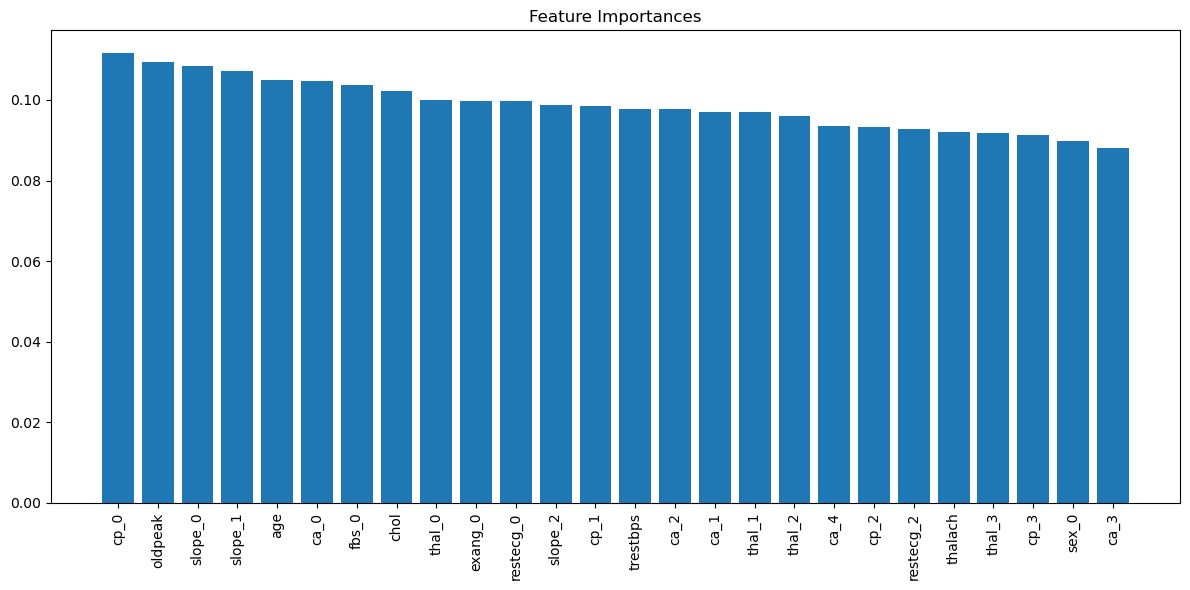

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(90,100,30), max_iter=9000, random_state=42,activation='relu',solver='adam')
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(Y_test, Y_pred))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))
import matplotlib.pyplot as plt
#plot the relevance of each feature
importances = model.coefs_[0]
feature_names = X.columns
avg_importances = np.mean(np.abs(importances), axis=1)
indices = np.argsort(avg_importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), avg_importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, Y_train)
gb_Y_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(Y_test, gb_Y_pred)
print(f"Gradient Boosting Model Accuracy: {gb_accuracy:.2f}")
print("Gradient Boosting Classification Report:")
print(classification_report(Y_test, gb_Y_pred))
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(Y_test, gb_Y_pred))


Gradient Boosting Model Accuracy: 0.79
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78        41
           1       0.83      0.78      0.80        50

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.79      0.79      0.79        91

Gradient Boosting Confusion Matrix:
[[33  8]
 [11 39]]
